In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
image_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    if dirname == '/kaggle/input/darksidedrums':
        for filename in filenames:
            image_files.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from IPython.display import clear_output

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"there are {len(gpus)} gpus")
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

there are 1 gpus


2023-02-06 12:45:54.489119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 12:45:54.582157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 12:45:54.582949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# read all the images and generate a dataset
def generate_dataset(image_files):
    images = []
    
    # loop through all the image files
    for file in image_files:
        # read the image
        img = cv.imread(file)
        # convert it to binary
        img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        # add an extra channel to feed the cnn
        img = np.expand_dims(img,axis=2)
        
        images.append(img)
     
    # return all the images as numpy array
    return np.array(images)

In [6]:
dataset = generate_dataset(image_files)

In [7]:
dataset.shape

(783, 25, 256, 1)

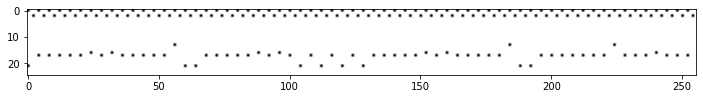

In [8]:
# visualize the first image of the dataset
plt.figure(figsize=(12,9))
plt.imshow(np.squeeze(dataset[0]),'gray')

In [9]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.initializers import RandomNormal

In [10]:
# define the standalone generator model
def define_generator(latent_dim):
    # define model
    model = Sequential()
    n_nodes = 64 * 5 * 128
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 128, 64)))

    model.add(Conv2DTranspose(64, (4,4), strides=(5,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (4,4), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

In [11]:
def define_discriminator(in_shape=(25,256,1)):
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [12]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [13]:
from matplotlib import pyplot
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(2 * 2):
        # define subplot
        pyplot.subplot(2, 2, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0]*255, cmap='gray_r')
    # save plot to file
    pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
    pyplot.close()
    # save the generator model
    #g_model.save('results_baseline/model_%03d.h5' % (step+1))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.close()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
            (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim,4)
            
        if (i+1) % (4*bat_per_epo) == 0:
            g_model.save('results_baseline/model_%03d.h5' % (i+1))
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
 
# make folder for results
os.makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 50
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
print(dataset.shape)

2023-02-06 12:46:44.469793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 12:46:44.470208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 12:46:44.471021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 12:46:44.471679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

(783, 25, 256, 1)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
#dataset = dataset / 255
dataset = dataset.astype('float32')
# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

In [15]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim,n_batch=128,n_epochs=1000)

2023-02-06 12:47:27.824222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 12:47:28.714258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, d1=0.710, d2=0.694 g=0.693, a1=9, a2=0
>2, d1=0.472, d2=0.696 g=0.691, a1=100, a2=0
>3, d1=0.306, d2=0.703 g=0.684, a1=100, a2=0
>4, d1=0.178, d2=0.716 g=0.671, a1=100, a2=0
>5, d1=0.101, d2=0.739 g=0.650, a1=100, a2=0
>6, d1=0.060, d2=0.771 g=0.623, a1=100, a2=0
>7, d1=0.043, d2=0.819 g=0.590, a1=100, a2=0
>8, d1=0.039, d2=0.878 g=0.553, a1=100, a2=0
>9, d1=0.044, d2=0.941 g=0.522, a1=100, a2=0
>10, d1=0.059, d2=0.999 g=0.501, a1=100, a2=0
>11, d1=0.089, d2=1.043 g=0.490, a1=100, a2=0
>12, d1=0.134, d2=1.050 g=0.493, a1=100, a2=0
>13, d1=0.192, d2=1.044 g=0.503, a1=100, a2=0
>14, d1=0.250, d2=1.018 g=0.521, a1=100, a2=0
>15, d1=0.292, d2=0.983 g=0.549, a1=100, a2=0
>16, d1=0.339, d2=0.930 g=0.576, a1=100, a2=0
>17, d1=0.369, d2=0.897 g=0.608, a1=100, a2=0
>18, d1=0.401, d2=0.847 g=0.640, a1=100, a2=0
>19, d1=0.410, d2=0.808 g=0.673, a1=100, a2=0
>20, d1=0.397, d2=0.772 g=0.710, a1=100, a2=0
>21, d1=0.401, d2=0.731 g=0.747, a1=100, a2=0
>22, d1=0.412, d2=0.703 g=0.778, a1=100, a2=2

2023-02-06 12:49:21.382999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>375, d1=0.654, d2=0.573 g=1.083, a1=50, a2=87
>376, d1=0.623, d2=0.546 g=1.097, a1=53, a2=89
>377, d1=0.578, d2=0.527 g=1.127, a1=65, a2=96
>378, d1=0.631, d2=0.525 g=1.092, a1=53, a2=93
>379, d1=0.686, d2=0.540 g=1.043, a1=46, a2=96
>380, d1=0.663, d2=0.607 g=1.025, a1=54, a2=85
>381, d1=0.680, d2=0.572 g=1.059, a1=59, a2=90
>382, d1=0.628, d2=0.558 g=1.087, a1=46, a2=93
>383, d1=0.697, d2=0.561 g=1.056, a1=53, a2=96
>384, d1=0.576, d2=0.541 g=1.087, a1=60, a2=92
>385, d1=0.746, d2=0.566 g=1.064, a1=50, a2=96
>386, d1=0.617, d2=0.547 g=1.089, a1=54, a2=98
>387, d1=0.622, d2=0.530 g=1.089, a1=54, a2=96
>388, d1=0.656, d2=0.561 g=1.057, a1=51, a2=90
>389, d1=0.657, d2=0.543 g=1.051, a1=45, a2=98
>390, d1=0.695, d2=0.588 g=1.041, a1=43, a2=82
>391, d1=0.596, d2=0.548 g=1.052, a1=53, a2=96
>392, d1=0.620, d2=0.556 g=1.077, a1=59, a2=90
>393, d1=0.665, d2=0.539 g=1.042, a1=46, a2=96
>394, d1=0.595, d2=0.585 g=1.076, a1=54, a2=82
>395, d1=0.661, d2=0.585 g=1.057, a1=43, a2=87
>396, d1=0.64

2023-02-06 12:51:11.042195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>766, d1=0.601, d2=0.570 g=1.015, a1=65, a2=90
>767, d1=0.545, d2=0.555 g=1.040, a1=68, a2=95
>768, d1=0.585, d2=0.537 g=1.060, a1=59, a2=89
>769, d1=0.539, d2=0.521 g=1.062, a1=73, a2=95
>770, d1=0.626, d2=0.549 g=1.042, a1=62, a2=93
>771, d1=0.606, d2=0.551 g=1.023, a1=57, a2=93
>772, d1=0.596, d2=0.556 g=1.022, a1=59, a2=95
>773, d1=0.576, d2=0.554 g=1.046, a1=67, a2=90
>774, d1=0.567, d2=0.587 g=1.020, a1=64, a2=84
>775, d1=0.643, d2=0.565 g=1.001, a1=43, a2=87
>776, d1=0.623, d2=0.602 g=0.979, a1=60, a2=81
>777, d1=0.535, d2=0.578 g=1.003, a1=81, a2=84
>778, d1=0.570, d2=0.539 g=1.015, a1=64, a2=87
>779, d1=0.621, d2=0.585 g=1.001, a1=62, a2=81
>780, d1=0.590, d2=0.580 g=0.980, a1=67, a2=81
>781, d1=0.652, d2=0.576 g=0.979, a1=68, a2=81
>782, d1=0.558, d2=0.586 g=1.010, a1=73, a2=82
>783, d1=0.575, d2=0.573 g=1.010, a1=71, a2=85
>784, d1=0.627, d2=0.552 g=1.039, a1=67, a2=90
>785, d1=0.550, d2=0.547 g=1.001, a1=68, a2=93
>786, d1=0.534, d2=0.552 g=1.003, a1=68, a2=92
>787, d1=0.49

2023-02-06 12:52:00.863441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>943, d1=0.614, d2=0.576 g=1.023, a1=71, a2=87
>944, d1=0.563, d2=0.546 g=1.085, a1=70, a2=98
>945, d1=0.646, d2=0.561 g=1.041, a1=59, a2=92
>946, d1=0.540, d2=0.553 g=1.059, a1=64, a2=87
>947, d1=0.632, d2=0.543 g=1.034, a1=62, a2=90
>948, d1=0.650, d2=0.563 g=0.984, a1=56, a2=90
>949, d1=0.573, d2=0.576 g=1.038, a1=67, a2=89
>950, d1=0.593, d2=0.576 g=1.046, a1=70, a2=89
>951, d1=0.661, d2=0.596 g=0.973, a1=57, a2=84
>952, d1=0.528, d2=0.565 g=1.035, a1=68, a2=90
>953, d1=0.591, d2=0.556 g=1.047, a1=70, a2=93
>954, d1=0.587, d2=0.564 g=1.054, a1=64, a2=93
>955, d1=0.648, d2=0.544 g=1.056, a1=60, a2=87
>956, d1=0.539, d2=0.537 g=1.052, a1=65, a2=95
>957, d1=0.570, d2=0.537 g=1.048, a1=59, a2=89
>958, d1=0.579, d2=0.548 g=1.060, a1=60, a2=90
>959, d1=0.643, d2=0.554 g=1.039, a1=51, a2=92
>960, d1=0.582, d2=0.542 g=1.046, a1=67, a2=93
>961, d1=0.560, d2=0.581 g=1.037, a1=59, a2=85
>962, d1=0.539, d2=0.516 g=1.055, a1=67, a2=96
>963, d1=0.585, d2=0.560 g=1.059, a1=59, a2=89
>964, d1=0.58

2023-02-06 13:03:06.794736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3316, d1=0.438, d2=0.500 g=1.322, a1=85, a2=93
>3317, d1=0.595, d2=0.449 g=1.268, a1=62, a2=95
>3318, d1=0.462, d2=0.486 g=1.257, a1=76, a2=90
>3319, d1=0.510, d2=0.452 g=1.211, a1=70, a2=95
>3320, d1=0.548, d2=0.469 g=1.169, a1=71, a2=89
>3321, d1=0.494, d2=0.519 g=1.207, a1=75, a2=82
>3322, d1=0.570, d2=0.519 g=1.213, a1=68, a2=93
>3323, d1=0.519, d2=0.452 g=1.221, a1=67, a2=92
>3324, d1=0.556, d2=0.480 g=1.162, a1=65, a2=89
>3325, d1=0.525, d2=0.541 g=1.284, a1=76, a2=81
>3326, d1=0.613, d2=0.447 g=1.161, a1=62, a2=93
>3327, d1=0.461, d2=0.570 g=1.245, a1=81, a2=75
>3328, d1=0.511, d2=0.478 g=1.256, a1=75, a2=92
>3329, d1=0.615, d2=0.497 g=1.233, a1=62, a2=84
>3330, d1=0.551, d2=0.517 g=1.181, a1=67, a2=84
>3331, d1=0.475, d2=0.495 g=1.215, a1=75, a2=84
>3332, d1=0.467, d2=0.465 g=1.200, a1=78, a2=90
>3333, d1=0.547, d2=0.471 g=1.108, a1=65, a2=87
>3334, d1=0.479, d2=0.494 g=1.225, a1=76, a2=85
>3335, d1=0.549, d2=0.467 g=1.195, a1=67, a2=89
>3336, d1=0.571, d2=0.532 g=1.148, a1=67